# Case Study

1. Install [allensdk](https://github.com/AllenInstitute/AllenSDK) in your python environment.
2. Go to alleninstitute cell-types [website](http://celltypes.brain-map.org/overview) and pick a cell for example this mouse [cell](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/483101699)
3. Under show neuronal responses from the drop-down menu pick a model type for example one of the LIF models -  the option to download the model will appear under the experiment. For detailed instructions you can go [here](https://allensdk.readthedocs.io/en/latest/biophysical_models.html). Note that for one of the biophysical models you will need to have Neuron installed with python as an alternative interprter. Instructions for installing neuron on unix systems are [here](https://neuron.yale.edu/neuron/download/compile_linux#otheroptions).
4. For this case study one of the GLIF models should suffice. Check the parameters of the model you downloaded. Use one of the noise stimulus to simulate the model. Running GLIF models through allensdk is documented [here](https://allensdk.readthedocs.io/en/latest/glif_models.html)
5. You would be fitting a Neural Network to get an estimate of the GLIF parameters. Sample parameters from the parameter space defined by the model you downloaded and simulate the models with the sampled parameters. For simulation you can either use allensdk run module or write your own simulator using the dynamics described [here](http://help.brain-map.org/download/attachments/8323525/GLIFModels.pdf?version=3&modificationDate=1508185195338&api=v2). The training set will comprise of these simulations with the simulated voltage under Noise stims as the input and the paramters as the output. For reference you can look at this [paper](https://www.biorxiv.org/content/biorxiv/early/2019/08/06/727974.1.full.pdf). 
6. Report the training, Validation and test score for the Neural network. Finally use the experimental Noise response as the input to the fitted NN to get the GLIF model.
7. Compare your GLIF model with the experiment and the fitted model you downloaded in Step 3, e.g., plot the traces. Run a comparison of the spikecounts and the spike times for the 3 cases for noise and other stimulus types as well (Long DC, Ramp). You can extract these features using allensdk ephys [package](https://allensdk.readthedocs.io/en/latest/allensdk.ephys.html), in particular [here](https://allensdk.readthedocs.io/en/latest/_modules/allensdk/ephys/ephys_features.html#detect_putative_spikes). You may have to adjust the default spike detection parameters (for the models) since these are set for biophysically realistic spikes. 

Parameters:

Mouse Line 	Cux2-CreERT2
ID 	483101699
Area 	Primary visual area
Layer 	4
Cell Reporter 	
Dendrite Type 	spiny
Apical Dendrite 	intact
Hemisphere 	left
Upstroke:downstroke ratio 	4.07
Adaptation Index 	0.023
Rheobase 	150
Membrane Time Constant 	15.2
Firing Rate 	11.3
Input Resistance 	118
Ramp Spike Time 	7.264
Resting Potential 	-78.1
F/I Curve Slope 	0.1

In [3]:
# Download files 

from allensdk.api.queries.glif_api import GlifApi
from allensdk.core.cell_types_cache import CellTypesCache
import allensdk.core.json_utilities as json_utilities

neuronal_model_id = 485513169

# download model metadata
glif_api = GlifApi()
nm = glif_api.get_neuronal_models_by_id([neuronal_model_id])[0]

# download the model configuration file
nc = glif_api.get_neuron_configs([neuronal_model_id])[neuronal_model_id]
neuron_config = glif_api.get_neuron_configs([neuronal_model_id])
json_utilities.write('neuron_config.json', neuron_config)

# download information about the cell
ctc = CellTypesCache()
ctc.get_ephys_data(nm['specimen_id'], file_name='stimulus.nwb')
ctc.get_ephys_sweeps(nm['specimen_id'], file_name='ephys_sweeps.json')

print("downloaded neuron model files")

2019-09-11 15:22:11,503 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/496605995


[{'bridge_balance_mohm': None,
  'id': 483102783,
  'leak_pa': None,
  'num_spikes': None,
  'peak_deflection': None,
  'post_noise_rms_mv': None,
  'post_vm_mv': None,
  'pre_noise_rms_mv': None,
  'pre_vm_mv': None,
  'slow_noise_rms_mv': None,
  'slow_vm_mv': None,
  'specimen_id': 483101699,
  'stimulus_absolute_amplitude': None,
  'stimulus_description': 'EXTPSMOKET141203[0]',
  'stimulus_duration': None,
  'stimulus_interval': None,
  'stimulus_name': 'Test',
  'stimulus_relative_amplitude': 1.0,
  'stimulus_start_time': None,
  'stimulus_units': 'Volts',
  'sweep_number': 0,
  'vm_delta_mv': None},
 {'bridge_balance_mohm': None,
  'id': 483102785,
  'leak_pa': None,
  'num_spikes': None,
  'peak_deflection': None,
  'post_noise_rms_mv': None,
  'post_vm_mv': None,
  'pre_noise_rms_mv': None,
  'pre_vm_mv': None,
  'slow_noise_rms_mv': None,
  'slow_vm_mv': None,
  'specimen_id': 483101699,
  'stimulus_absolute_amplitude': None,
  'stimulus_description': 'EXTPINBATH141203[0]',
  

In [6]:
import allensdk.core.json_utilities as json_utilities
from allensdk.model.glif.glif_neuron import GlifNeuron
from allensdk.core.nwb_data_set import NwbDataSet

neuron_id = "485513169"

neuron_config = json_utilities.read('src/neuron_config.json')
ephys_sweeps = json_utilities.read('src/ephys_sweeps.json')
ephys_file_name = 'src/stimulus.nwb'

# pull out the stimulus for the current-clamp first sweep
ephys_sweep = next(s for s in ephys_sweeps 
                    if s['stimulus_units'] == 'Amps')
ds = NwbDataSet(ephys_file_name)
data = ds.get_sweep(ephys_sweep['sweep_number']) 
stimulus = data['stimulus']

# initialize the neuron
# important! update the neuron's dt for your stimulus
neuron = GlifNeuron.from_dict(neuron_config[neuron_id])
neuron.dt = 1.0 / data['sampling_rate']

# simulate the neuron
output = neuron.run(stimulus)

voltage = output['voltage']
threshold = output['threshold']
spike_times = output['interpolated_spike_times']

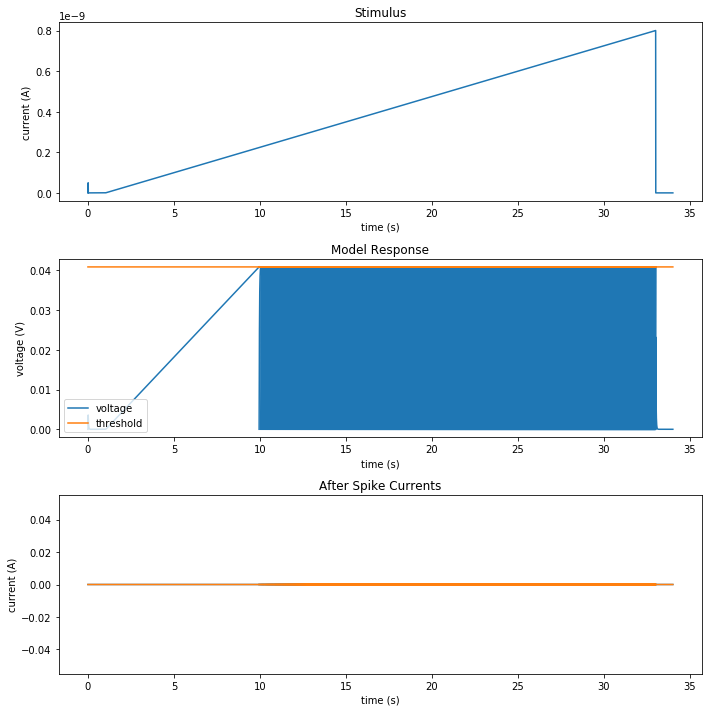

In [8]:
## Plotting 

import numpy as np
import matplotlib.pyplot as plt

voltage = output['voltage']
threshold = output['threshold']
interpolated_spike_times = output['interpolated_spike_times']
spike_times = output['interpolated_spike_times']
interpolated_spike_voltages = output['interpolated_spike_voltage']
interpolated_spike_thresholds = output['interpolated_spike_threshold']
grid_spike_indices = output['spike_time_steps']
grid_spike_times = output['grid_spike_times']
after_spike_currents = output['AScurrents']

# create a time array for plotting
time = np.arange(len(stimulus))*neuron.dt

plt.figure(figsize=(10, 10))

# plot stimulus
plt.subplot(3,1,1)
plt.plot(time, stimulus)
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.title('Stimulus')

# plot model output
plt.subplot(3,1,2)
plt.plot(time,  voltage, label='voltage')
plt.plot(time,  threshold, label='threshold')

#if grid_spike_indices is not None:
#    plt.plot(interpolated_spike_times, interpolated_spike_voltages, 'x', 
#             label='interpolated spike')

#    plt.plot((grid_spike_indices-1)*neuron.dt, voltage[grid_spike_indices-1], '.', 
#             label='last step before spike')

plt.xlabel('time (s)')
plt.ylabel('voltage (V)')
plt.legend(loc=3)
plt.title('Model Response')

# plot after spike currents
plt.subplot(3,1,3)
for ii in range(np.shape(after_spike_currents)[1]):
    plt.plot(time, after_spike_currents[:,ii])
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.title('After Spike Currents')

plt.tight_layout()
plt.show()